## Applied - Question 10

This question will use weekly dataset from ISLR R-package. It includes weekly percentage 
returns for the S&P 500 stock index between 1990 and 2010. 
A data frame with 1089 observations on the following 9 variables:
  1. Year: The year that the observation was recorded
  2. Lag1: Percentage return for previous week
  3. Lag2: Percentage return for 2 weeks previous
  4. Lag3: Percentage return for 3 weeks previous
  5. Lag4: Percentage return for 4 weeks previous
  6. Lag5: Percentage return for 5 weeks previous
  7. Volume: Volume of shares traded (average number of daily shares traded in billions)
  8. Today: Percentage return for this week
  9. Direction: A factor with levels Down and Up indicating whether the market had a positive or negative return on a given week

#### Import block

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import preprocessing, neighbors

from util import print_cm

%matplotlib inline
plt.style.use('seaborn-white')

Getting the data

In [2]:
data_path = 'D:\\PycharmProjects\\ISLR\\data\\'
df = pd.read_csv(f'{data_path}Weekly.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089 entries, 0 to 1088
Data columns (total 9 columns):
Year         1089 non-null int64
Lag1         1089 non-null float64
Lag2         1089 non-null float64
Lag3         1089 non-null float64
Lag4         1089 non-null float64
Lag5         1089 non-null float64
Volume       1089 non-null float64
Today        1089 non-null float64
Direction    1089 non-null object
dtypes: float64(7), int64(1), object(1)
memory usage: 76.7+ KB
None


,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


As always, we start with the pairplots

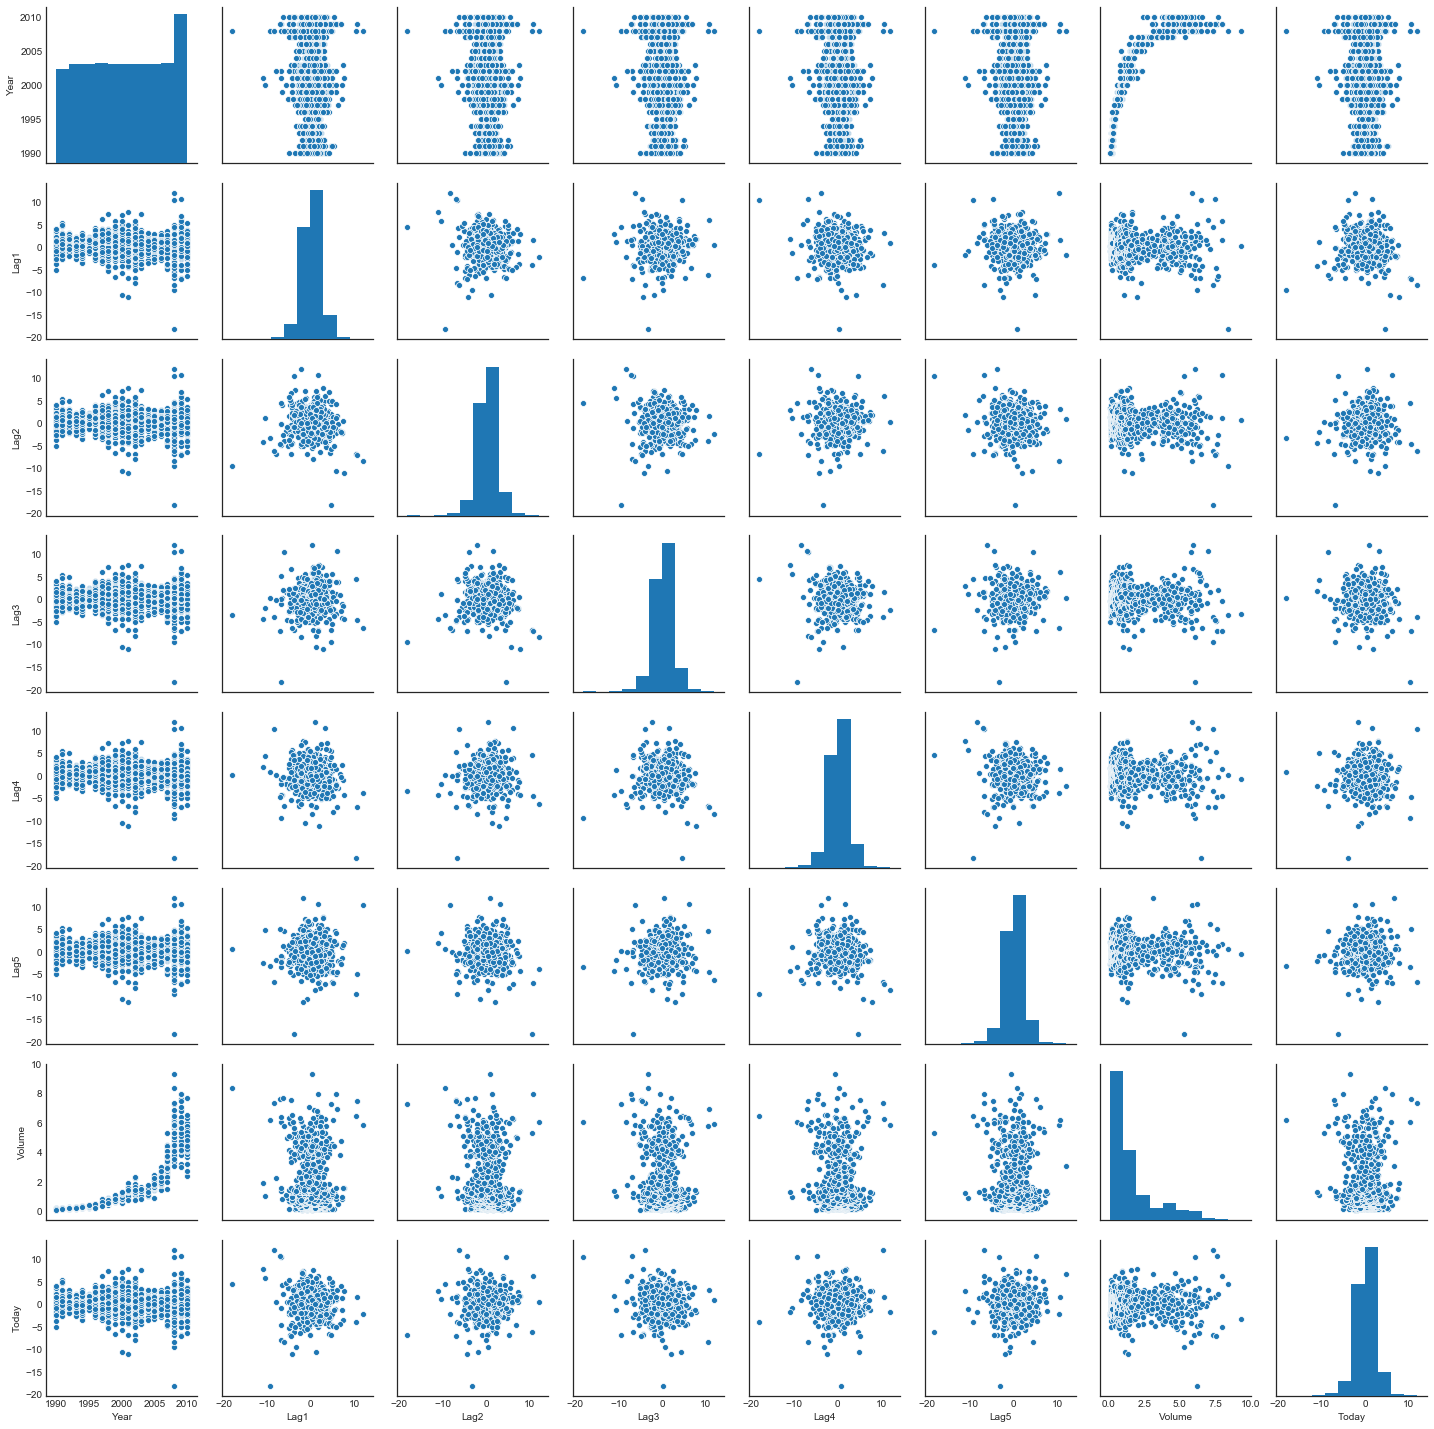

In [24]:
sns.pairplot(df)

There are some easy observation here:  
1. The trade volume is increasing steadily over the year. 
2. There is no clear pattern between weekly average returns. It has no memory. 
3. Stock returns follows the tight distribution with small variance but there are some outliers.

(b) Using full dataset

In [4]:
df2 = pd.DataFrame.copy(df, deep=True)
df2['Direction2'] = df2['Direction'].astype('category').cat.codes
form = 'Direction2 ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume'
model_fit = smf.logit(form, data=df2).fit()
print(model_fit.summary().tables[1])

Optimization terminated successfully.
         Current function value: 0.682441
         Iterations 4
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2669      0.086      3.106      0.002       0.098       0.435
Lag1          -0.0413      0.026     -1.563      0.118      -0.093       0.010
Lag2           0.0584      0.027      2.175      0.030       0.006       0.111
Lag3          -0.0161      0.027     -0.602      0.547      -0.068       0.036
Lag4          -0.0278      0.026     -1.050      0.294      -0.080       0.024
Lag5          -0.0145      0.026     -0.549      0.583      -0.066       0.037
Volume        -0.0227      0.037     -0.616      0.538      -0.095       0.050


As expected, previous weeks returns offer little to no insight on how the market will perform. We
can see except for Lag2 (p=0.03), all other coefficient is statistically insignificant. 

Confusion matrix as follow. Note that we are switching to skl package

In [5]:
y = df.Direction
X = df.drop(['Today', 'Direction', 'Year'], axis=1)
regr = skl_lm.LogisticRegression(solver='newton-cg')
regr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [6]:
pred = regr.predict(X)
print_cm(y, pred, regr)

Confusion Matrix 
 True       Down   Up
Predicted           
Down         54   48
Up          430  557 

Classification report 
               precision    recall  f1-score   support

        Down       0.53      0.11      0.18       484
          Up       0.56      0.92      0.70       605

    accuracy                           0.56      1089
   macro avg       0.55      0.52      0.44      1089
weighted avg       0.55      0.56      0.47      1089



The report gives us an accuracy of 0.56 and an avg. precision of 0.55. The confusion matrix told us
2 type of mistakes here:
1. The False positive, as in predicted of UP but it is DOWN. Type II error.
False Positive rate = 430/(430+54) = 0.888  
Thus, specificity(avoidance of False positive) is 0.112
2. The False negative, as in predicted of DOWN but it is UP. Type I error.
False Negative rate = 48/(48+557) = 0.079  
Thus, recall/sensitivity(avoidance of False negative) is 0.921

(d) Train set from 1990 to 2008 and Lag2. Test set from 2009 to 2010 

In [7]:
X_train = df.loc[df['Year'] < 2009]['Lag2'].values.reshape(-1,1)
y_train = df.loc[df['Year'] < 2009]['Direction']

X_test = df.loc[df['Year'] > 2008]['Lag2'].values.reshape(-1,1)
y_test = df.loc[df['Year'] > 2008]['Direction']

regr = skl_lm.LogisticRegression(solver='newton-cg')
regr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [11]:
pred = regr.predict(X_test)
print_cm(y_test, pred, regr)

Confusion Matrix 
 True       Down  Up
Predicted          
Down          9   5
Up           34  56 

Classification report 
               precision    recall  f1-score   support

        Down       0.64      0.21      0.32        43
          Up       0.62      0.92      0.74        61

    accuracy                           0.62       104
   macro avg       0.63      0.56      0.53       104
weighted avg       0.63      0.62      0.57       104



We get a 0.62 accuracy with 0.64 average precision. The sensitivity = 0.92 and specificity = 0.21

(e) LDA model

In [12]:
lda = LinearDiscriminantAnalysis() 
pred = lda.fit(X_train, y_train).predict(X_test)
print_cm(y_test, pred, lda)

Confusion Matrix 
 True       Down  Up
Predicted          
Down          9   5
Up           34  56 

Classification report 
               precision    recall  f1-score   support

        Down       0.64      0.21      0.32        43
          Up       0.62      0.92      0.74        61

    accuracy                           0.62       104
   macro avg       0.63      0.56      0.53       104
weighted avg       0.63      0.62      0.57       104



(f) QDA model

In [14]:
qda = QuadraticDiscriminantAnalysis() 
pred = qda.fit(X_train, y_train).predict(X_test)
print_cm(y_test, pred, qda)

Confusion Matrix 
 True       Down  Up
Predicted          
Down          0   0
Up           43  61 

Classification report 
               precision    recall  f1-score   support

        Down       0.00      0.00      0.00        43
          Up       0.59      1.00      0.74        61

    accuracy                           0.59       104
   macro avg       0.29      0.50      0.37       104
weighted avg       0.34      0.59      0.43       104



d:\pycharmprojects\islr\venv\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(g) KNN with K = 1

In [23]:
knn = neighbors.KNeighborsClassifier(n_neighbors=1)
pred = knn.fit(X_train, y_train).predict(X_test)
print_cm(y_test, pred, knn)

Confusion Matrix 
 True       Down  Up
Predicted          
Down         21  31
Up           22  30 

Classification report 
               precision    recall  f1-score   support

        Down       0.40      0.49      0.44        43
          Up       0.58      0.49      0.53        61

    accuracy                           0.49       104
   macro avg       0.49      0.49      0.49       104
weighted avg       0.51      0.49      0.49       104



We have the following accuracy ranking:
1. Logistic = LDA = 0.62
2. QDA = 0.59 (which is the route of choosing up ALWAYS!)
3. KNN(K=1) = 0.49

There are no clear pattern between Directions and other predictors. There is also none
between Lag2 and others. Thus, running other permuations might not be a good idea.

However, we can try to increase our KNN prediction.

KNN with K = 3

In [31]:
knn = neighbors.KNeighborsClassifier(n_neighbors=3)
pred = knn.fit(X_train, y_train).predict(X_test)
print_cm(y_test, pred, knn)

Confusion Matrix 
 True       Down  Up
Predicted          
Down         15  20
Up           28  41 

Classification report 
               precision    recall  f1-score   support

        Down       0.43      0.35      0.38        43
          Up       0.59      0.67      0.63        61

    accuracy                           0.54       104
   macro avg       0.51      0.51      0.51       104
weighted avg       0.53      0.54      0.53       104



KNN with K = 5

In [32]:
knn = neighbors.KNeighborsClassifier(n_neighbors=5)
pred = knn.fit(X_train, y_train).predict(X_test)
print_cm(y_test, pred, knn)

Confusion Matrix 
 True       Down  Up
Predicted          
Down         16  22
Up           27  39 

Classification report 
               precision    recall  f1-score   support

        Down       0.42      0.37      0.40        43
          Up       0.59      0.64      0.61        61

    accuracy                           0.53       104
   macro avg       0.51      0.51      0.50       104
weighted avg       0.52      0.53      0.52       104

